In [1]:
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst, wf_from_files, WfType
from invisible_cities.core.core_functions import in_range
from invisible_cities.database  import load_db
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from scipy.signal import find_peaks
from scipy.signal import wiener
from scipy.signal import butter, filtfilt
from pathlib  import Path
from scipy.interpolate import interp1d

import sys
from datetime import datetime


In [2]:
def find_highest_wf(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    wfs[16] = np.arange(wfs[16] .size) * 0
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return wfs[index]

def find_highest_sipm(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return index

In [121]:
def sum_wf1(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]

    element_wise_sum = np.zeros_like(wfs[0],dtype=np.int64)

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def ADC_to_PE(wfs, datapmt):
    conv_factors = datapmt.adc_to_pes.to_numpy()

    for w in range(0, len(wfs)):
        if (conv_factors[w] == 1e5):
            conv_factors[w] = 0
        wfs[w] = wfs[w]*conv_factors[w]

    return wfs


def check_summed_baseline(wfs_sum, grass_lim, scale_factor):

    flag=False
    tc=25e-3
    
    # Check the baseline at the end and start match
    # otherwise there could be signal there so the baseline is all messed up
    num_samples = int(25/tc)
    baseline1=np.mean(wfs_sum[-num_samples:])
    baseline2=np.mean(wfs_sum[0:int(25/tc)])

    # 20 seems like a good number to check the difference against
    if (abs(baseline1-baseline2) > 20*scale_factor):
        print("Error in baselines at start and end, dropping event")
        print(baseline1-baseline2)
        flag = True

    # Look in the window for large peaks that could be other S2 pulses. 
    # This will mess up the reconstruction
    peaks, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=2000, distance=30/tc)

    # print(peaks*tc)

    # print(wfs_sum[int(peaks[0] + grass_lim[0]/tc - 5/tc) : int(peaks[0] + grass_lim[0]/tc + 5/tc)].sum())

    peaks_filt = np.array([
        p for p in peaks
        if wfs_sum[int(p + grass_lim[0]/tc - 5/tc) : int(p + grass_lim[0]/tc + 5/tc)].sum() > 1e6
    ])

    return flag, peaks_filt

def get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim):

    df = []

    wfs = wfs[:, tsel]

    for pmt_no, wf in enumerate(wfs):

        idx_over_thr = np.argwhere(wf > noise[pmt_no]).flatten()
        splits       = np.argwhere(np.diff(idx_over_thr) > thr_split).flatten()
        idx_slices   = np.split(idx_over_thr, splits+1)
        idx_slices   = list(filter(lambda sl: in_range(len(sl), peak_minlen, peak_maxlen + .5), idx_slices))

        for sl in idx_slices:
            m = np.argmax(wf[sl]) + sl[0]
            pe_int = wf[m-half_window:m+half_window].sum()
            df.append(pd.DataFrame(dict(event = evt_info[evt_no][0], ts_raw=ts/1e3, pmt=pmt_no, pe_int=pe_int, peak_time=m*tc+grass_lim[0], noise_thr=noise[pmt_no]), index=[0]))

    return df


def CorrectRawBaseline(wfs):

    corrected_waveforms = []

    for wfm in wfs:
        num_samples = int(25/tc)
        baseline1=np.mean(wfm[-num_samples:])
        baseline2=np.mean(wfm[0:int(25/tc)])
        wfm = -1*(wfm-baseline2)
        corrected_waveforms.append(wfm)

    return np.array(corrected_waveforms)


def find_fwhm(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    # First crossing point
    left_idx = above_half_max[0]
    right_idx = above_half_max[-1]

    # Interpolate to get more accurate crossing times
    t_left = np.interp(half_max, [amplitude[left_idx-1], amplitude[left_idx]], [time[left_idx-1], time[left_idx]])
    t_right = np.interp(half_max, [amplitude[right_idx], amplitude[right_idx+1]], [time[right_idx], time[right_idx+1]])

    fwhm = t_right - t_left
    return fwhm, max_amplitude


# Get interpolation of the background noise just after the S2
def GetBaselineInterp(noise, wfs, t_pmt):

    interps = []
    for pmt_no, wf in enumerate(wfs):
        threshold = noise[pmt_no]

        # Select points where amplitude is below the threshold
        mask = (wf < threshold) & (wf > -threshold)
        filtered_time = t_pmt[mask]
        filtered_amplitude = wf[mask]

        if (len(filtered_amplitude) == 0):
            filtered_time = t_pmt
            filtered_amplitude = np.zeros(len(t_pmt))
        
        # Generate smooth line over the full time range
        smoothed_amplitude = savgol_filter(filtered_amplitude, 301, 1)

        # Interpolate the smoothed data
        interp_func = interp1d(filtered_time, smoothed_amplitude, kind='cubic', bounds_error=False, fill_value=0)  # Cubic interpolation for smoothness
        interps.append(interp_func)

    return interps


# Uses the interpolation in a range to fix the baseline
def CorrectDeconvBaseline(t_pmt, tmin, tmax, interps, wfs):
    
    for pmt_no, wf in enumerate(wfs):
        # Apply the interpolation function to waveform time points
        amplitude_interpolated = interps[pmt_no](t_pmt)
        mask = (t_pmt < tmin) | (t_pmt > tmax)
        amplitude_interpolated[mask] = 0

        # Subtract the interpolated amplitude from the waveform amplitude
        wfs[pmt_no] = wf - amplitude_interpolated

    return wfs


In [40]:
filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
filename  = "../data/xenon/run_14498_0011_ldc3_trg0.waveforms.h5"

raw_evts = pd.read_hdf(filename, '/Run/events')
display(raw_evts)
print(raw_evts.evt_number.unique())

raw_evts = load_dst(filename, 'Run', 'events')
nrwfs = len(raw_evts.evt_number.unique())
print("Number of Waveforms:", nrwfs)


,evt_number,timestamp
0,4550,1730123253196
1,4557,1730123253375
2,4564,1730123253626
3,4571,1730123253869
4,4578,1730123254080
5,4585,1730123254249
6,4592,1730123254634
7,4599,1730123254839
8,4606,1730123255090
9,4613,1730123255396


[4550 4557 4564 4571 4578 4585 4592 4599 4606 4613 4620 4627 4634 4641
 4648 4655 4662 4669 4676 4683 4690 4697 4704 4711 4718 4725 4732 4739
 4746 4753 4760 4767 4774 4781 4788 4795 4802 4809 4816 4823 4830 4837
 4844 4851 4858 4865 4872 4879 4886 4893 4900 4907 4914 4921 4928 4935
 4942 4949 4956]
Number of Waveforms: 59


In [66]:
# Load in the database for SiPMs

# RUN_NUMBER = 13852
RUN_NUMBER = 14498

deconv = deconv_pmt("next100", RUN_NUMBER, 62400)

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, RUN_NUMBER)
datapmt = load_db.DataPMT(detector_db, RUN_NUMBER)

datasipm_correct = load_db.DataSiPM(detector_db, 14450)
datasipm_correct = datasipm_correct[["SensorID", "ChannelID", "X", "Y"]]
datasipm = datasipm[["SensorID", "ChannelID", "X", "Y"]]

data_sipm_merge  = pd.merge(datasipm, datasipm_correct, on='SensorID', how='inner')

display(datasipm)
display(datasipm_correct)

# display(data_sipm_merge[ (data_sipm_merge['X_x'] != data_sipm_merge['X_y'] ) | (data_sipm_merge['Y_x'] != data_sipm_merge['Y_y'] )])

# display(datapmt)

thr_split   = 2      # maximum number of samples allowed to be below threshold to consider it a peak
peak_minlen = 2      # minimum number of samples above threshold in a peak
peak_maxlen = 10     # maximum number of samples above threshold in a peak
half_window = 4      # number of samples to each side of a peak maximum to integrate
tc          = 25e-3  # constant to convert from samples to time or vice versa. 
noise_sigma = 4      # how many STD above noise for the single PEs to be
scale_factor = 40*60 # Scale factor for summed waveform. 60 Pmts, 40 is ~ the conversion factor

dead_pmts = [3, 16, 24, 36, 37, 38, 39,40, 41, 48, 53, 58]

if (RUN_NUMBER == 13850 or RUN_NUMBER == 13852):
    grass_lim   = 1050, 1770 # time window in mus in which to search for single pes
    noise_lim   = 1900, 2000 # time window to calculate the noise baseline
    S1_height   = 10000
    S2_height   = 50000
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end
    Cath_start  = 1793       # start window for cathode events
    Cath_end    = 1810       # end window for cathode events
    S1_window   = 100, 985   # window to search for S1
    S2_window   = 985, 1200  # window to search for S2

elif (RUN_NUMBER == 14180):
    grass_lim   = 1050, 1770 
    noise_lim   = 1900, 2000 
    S1_height   = 10000
    S2_height   = 50000
    S2_start    = 990
    S2_end      = 1040
    Cath_start  = 1796
    Cath_end    = 1812
    S1_window   = 100, 985
    S2_window   = 985, 1200 

elif (RUN_NUMBER == 14498):
    grass_lim   = 1650, 2350
    noise_lim   = 2500, 2600
    S1_height   = 20000
    S2_height   = 50000
    S2_start    = 1590
    S2_end      = 1640
    Cath_start  = 2500
    Cath_end    = 2550
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 

else:
    print("Unknown RUN Configured")


useRaw = False



,SensorID,ChannelID,X,Y
0,1000,56013,-482.625,-294.825
1,1001,56012,-482.625,-279.275
2,1002,56015,-482.625,-263.725
3,1003,56014,-482.625,-248.175
4,1004,56029,-482.625,-232.625
...,...,...,...,...
3579,56059,14054,490.025,245.425
3580,56060,14037,490.025,260.975
3581,56061,14036,490.025,276.525
3582,56062,14039,490.025,292.075


,SensorID,ChannelID,X,Y
0,1000,56013,-482.625,-294.825
1,1001,56012,-482.625,-279.275
2,1002,56015,-482.625,-263.725
3,1003,56014,-482.625,-248.175
4,1004,56029,-482.625,-232.625
...,...,...,...,...
3579,56059,14054,490.025,245.425
3580,56060,14037,490.025,260.975
3581,56061,14036,490.025,276.525
3582,56062,14039,490.025,292.075


On Event: 0
1356
-96.875 -294.325
0
event failed min baseline
On Event: 1
On Event: 2
On Event: 3
On Event: 4
On Event: 5
On Event: 6
On Event: 7
On Event: 8
On Event: 9
On Event: 10
On Event: 11
On Event: 12
On Event: 13
On Event: 14
On Event: 15
On Event: 16
On Event: 17
On Event: 18
On Event: 19
On Event: 20
On Event: 21
On Event: 22
On Event: 23
On Event: 24
On Event: 25
On Event: 26
On Event: 27
On Event: 28
On Event: 29
On Event: 30
On Event: 31
On Event: 32
On Event: 33
On Event: 34
On Event: 35
On Event: 36
On Event: 37
On Event: 38
On Event: 39
On Event: 40
On Event: 41
On Event: 42
On Event: 43
On Event: 44
On Event: 45
On Event: 46
On Event: 47
On Event: 48
On Event: 49
On Event: 50
On Event: 51
On Event: 52
On Event: 53
On Event: 54
On Event: 55
On Event: 56
On Event: 57
On Event: 58


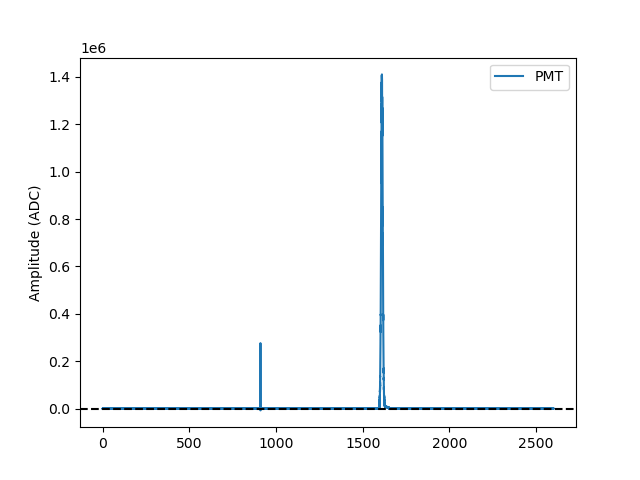

In [129]:
%matplotlib widget
# good events: 4,5,  37
event_number = 0

with tb.open_file(filename) as file:

    rwf      = file.root.RD.pmtrwf

    for evt_no, wfs in enumerate(rwf):

        print("On Event:", evt_no)
        if (evt_no != event_number):
            continue

        # if (evt_no > 10):
        #     break

        # wf_pmt  = find_highest_wf(file.root.RD. pmtrwf, event_number)

        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

        # Zero out the dead PMTs
        for pmt_ in dead_pmts:
            wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        
        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, event_number)

        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y
        print(x_pos, y_pos)

        sp_pmt  = 25e-3 # sampling period in mus
        sp_sipm = 1     # sampling period in mus
        times   = np.arange(wfs[0] .size) * sp_pmt
        t_sipm  = np.arange(highest_sipm.size) * sp_sipm

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        interps = GetBaselineInterp(noise, wfs, times)

        # Correct the waveforms
        wfs = CorrectDeconvBaseline(times, grass_lim[0], grass_lim[0]+500, interps, wfs) # Correct baseline 500 mus after the pulse

        index = np.argmax(np.max(wfs, axis=1))
        wf_pmt = wfs[33]
        
        wf_pmt = sum_wf(wfs)


        new_time = np.linspace(1000,2000,300)
        interpolated_amplitude = interps[0](new_time)

        plt.figure()
        plt.plot(times, wf_pmt , label = "PMT");
        plt.ylabel("Amplitude (ADC)")

        # plt.plot(filtered_time, filtered_amplitude, 'o', label="Filtered Points", color="red")
        # plt.plot(filtered_time, smoothed_amplitude, label="Smoothed Line", color="blue")
        # plt.plot(new_time, interpolated_amplitude, label="Interpolation", color="red")
        

        plt.axhline(y=0, color='black', linestyle='--')
        plt.legend(loc = "upper right")

        peaks, _ = find_peaks(wf_pmt[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height = 2000, distance = 30/tc)

        pass_flag, grass_peaks = check_summed_baseline(wf_pmt, grass_lim, scale_factor)
        print(len(grass_peaks))

        if (len(grass_peaks) > 0):
            plt.plot(t_pmt[grass_peaks+int(grass_lim[0]/25e-3)], wf_pmt[grass_peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')


        # Check the baseline, if we got something really negative
        # then the deconvolution likely failed, so skip grass calculation
        min_baseline = min(wf_pmt)
        if (min_baseline < -2000):
            print("event failed min baseline")


        plt.savefig(f"../plots/deconvolved/run_{RUN_NUMBER}_event{evt_no}.png")


In [132]:


folder_out = Path("../data/analysis/")


wf_sum = 0
wf_sum_clean = 0

data = []
data_properties = []
with tb.open_file(filename) as file:
    file_no=0
    evt_info = file.root.Run.events
    rwf      = file.root.RD.pmtrwf
    time     = np.arange(rwf.shape[2]) * tc
    tsel     = in_range(time, *grass_lim)
    for evt_no, wfs in enumerate(rwf):

        print("On Event:", evt_no, "real ID:", evt_info[evt_no][0])

        # if (evt_no != 11):
        #     continue

        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, evt_no)
        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y

        _, ts = evt_info[evt_no]
        
        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

       # Zero out the dead PMTs
        for pmt_ in dead_pmts:
            wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        
        wfs_sum = sum_wf(wfs)

        times   = np.arange(wfs_sum .size) * tc # sampling period in mus

        S1, _ = find_peaks(wfs_sum[ int(S1_window[0]/tc):int(S1_window[1]/tc)], height=S1_height, distance=40/tc)
        S2, _ = find_peaks(wfs_sum[ int(S2_window[0]/tc):int(S2_window[1]/tc)], height=S2_height, distance=200/tc)

        if (len(S1) ==0):
            print("No S1!")

        if (len(S2) ==0):
            print("No S2!")

        if (len(S1) !=1 or len(S2)!=1 ):
            deltaT = -999
        else:
            deltaT = S2[0]*tc+S2_window[0] - (S1[0]*tc+S1_window[0])
            # print("Time difference between S1 and S2:", deltaT)

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        interps = GetBaselineInterp(noise, wfs, times)

        # Correct the waveforms
        wfs = CorrectDeconvBaseline(times, grass_lim[0], grass_lim[0]+500, interps, wfs) # Correct baseline 500 mus after the pulse

        # wf_sum_clean+=wfs_sum

        wfs_sum_cor = sum_wf(wfs)
        wf_sum_clean+=wfs_sum_cor

        # Check if event failed the quality control, use corrected waveform
        pass_flag, grass_peaks = check_summed_baseline(wfs_sum_cor, grass_lim, scale_factor)
        if (pass_flag):
            print("Event Failed Quality Control...")
            continue

        print("Num Grass Peaks:", len(grass_peaks))


        # Sum values in the peak up to the point where the pulse goes to zero
        S2_area = wfs_sum[int(S2_start/tc):int(S2_end/tc)]
        S2_area = S2_area[S2_area > 0].sum()

        FWHM, S2_amplitude = find_fwhm(times[int(S2_start/tc):int(S2_end/tc)], wfs_sum[int(S2_start/tc):int(S2_end/tc)])
        print("Sigma is: ", FWHM/2.355)

        cath_df = get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, [Cath_start,Cath_end])
        cath_df = pd.concat(cath_df, ignore_index=True)
        cath_area = cath_df.pe_int.sum()
        
        data_properties.append(pd.DataFrame(dict(event = evt_info[evt_no][0], S2_area=S2_area,cath_area=cath_area, ts_raw=ts/1e3, deltaT=deltaT, sigma = FWHM/2.355, x = x_pos, y = y_pos, grass_peaks = len(grass_peaks), nS1 = len(S1)), index=[0]))

        # Check the baseline, if we got something really negative
        # then the deconvolution likely failed, so skip grass calculation
        min_baseline = min(wfs_sum[int((grass_lim[0]-50)/tc):int((grass_lim[0]+100)/tc)])
        if (min_baseline > -1000):
            df = get_PEs_inWindow(wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim)
            data = data + df
        else:
            print("Problem with deconvolution")

    data = pd.concat(data, ignore_index=True)
    data = data.assign(ts = np.array(list(map(datetime.fromtimestamp, data.ts_raw))))
    # data.to_hdf(file_out, "/data", complib="zlib", complevel=4, mode="w")

    data_properties = pd.concat(data_properties, ignore_index=True)
    data_properties = data_properties.assign(ts = np.array(list(map(datetime.fromtimestamp, data_properties.ts_raw))))



On Event: 0 real ID: 4550
1356
Num Grass Peaks: 0
Sigma is:  4.687048861356867
On Event: 1 real ID: 4557
3055
Num Grass Peaks: 0
Sigma is:  3.4225145194907913
On Event: 2 real ID: 4564
1019
Num Grass Peaks: 0
Sigma is:  3.895117105665338
On Event: 3 real ID: 4571
2290
Num Grass Peaks: 0
Sigma is:  6.169131143117462
On Event: 4 real ID: 4578
1356
Num Grass Peaks: 0
Sigma is:  3.187170477563308
On Event: 5 real ID: 4585
2976
Num Grass Peaks: 1
Sigma is:  6.109915714189245
On Event: 6 real ID: 4592
3482
Num Grass Peaks: 0
Sigma is:  6.10567934735716
On Event: 7 real ID: 4599
3161
Num Grass Peaks: 0
Sigma is:  6.226625721912102
On Event: 8 real ID: 4606
2705
Num Grass Peaks: 1
Sigma is:  2.9065122482616506
On Event: 9 real ID: 4613
623
Num Grass Peaks: 0
Sigma is:  5.789663182301339
On Event: 10 real ID: 4620
2693
No S1!
Num Grass Peaks: 0
Sigma is:  1.2189811489380498
Problem with deconvolution
On Event: 11 real ID: 4627
2752
No S1!
Num Grass Peaks: 0
Sigma is:  5.235795034437932
On Event

In [123]:
display(data)
display(data_properties)

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,4550,1.730123e+09,0,1730.732992,1656.350,121.339707,2024-10-28 08:47:33.196
1,4550,1.730123e+09,0,2326.133235,1698.325,121.339707,2024-10-28 08:47:33.196
2,4550,1.730123e+09,0,800.507125,1792.500,121.339707,2024-10-28 08:47:33.196
3,4550,1.730123e+09,0,2477.790330,2125.500,121.339707,2024-10-28 08:47:33.196
4,4550,1.730123e+09,0,2352.537031,2197.250,121.339707,2024-10-28 08:47:33.196
...,...,...,...,...,...,...,...
44621,4956,1.730123e+09,59,933.691598,1917.275,106.014045,2024-10-28 08:47:48.250
44622,4956,1.730123e+09,59,1144.652447,2022.325,106.014045,2024-10-28 08:47:48.250
44623,4956,1.730123e+09,59,765.517090,2235.475,106.014045,2024-10-28 08:47:48.250
44624,4956,1.730123e+09,59,923.623385,2242.875,106.014045,2024-10-28 08:47:48.250


,event,S2_area,cath_area,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,ts
0,4550,6.469990e+08,5.983898e+05,1.730123e+09,700.525,4.687049,-96.875,-294.325,0,1,2024-10-28 08:47:33.196
1,4557,6.753423e+08,4.076013e+05,1.730123e+09,361.275,3.422515,335.525,60.825,0,1,2024-10-28 08:47:33.375
2,4564,7.803946e+08,4.091933e+05,1.730123e+09,392.625,3.895117,-126.975,-63.075,0,1,2024-10-28 08:47:33.626
3,4571,5.523276e+08,7.664062e+05,1.730123e+09,1234.300,6.169131,104.275,414.975,0,1,2024-10-28 08:47:33.869
4,4578,6.440479e+08,4.603514e+05,1.730123e+09,329.675,3.187170,-96.875,-294.325,0,1,2024-10-28 08:47:34.080
5,4585,6.780653e+08,9.381719e+05,1.730123e+09,-999.000,6.109916,319.975,-171.425,1,2,2024-10-28 08:47:34.249
6,4592,2.577276e+08,3.082172e+05,1.730123e+09,1327.675,6.105679,427.825,106.475,0,1,2024-10-28 08:47:34.634
7,4599,7.116460e+08,1.007781e+06,1.730123e+09,1217.325,6.226626,304.425,214.325,0,1,2024-10-28 08:47:34.839
8,4606,6.817563e+08,3.355139e+06,1.730123e+09,-999.000,2.906512,165.475,276.025,1,2,2024-10-28 08:47:35.090
9,4613,6.620448e+08,8.494610e+05,1.730123e+09,1126.375,5.789663,-281.475,184.225,0,1,2024-10-28 08:47:35.396


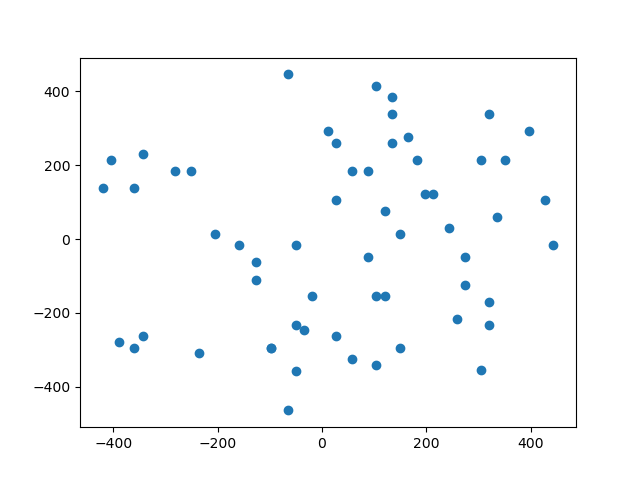

In [56]:
plt.figure()

plt.scatter(data_properties.x, data_properties.y)

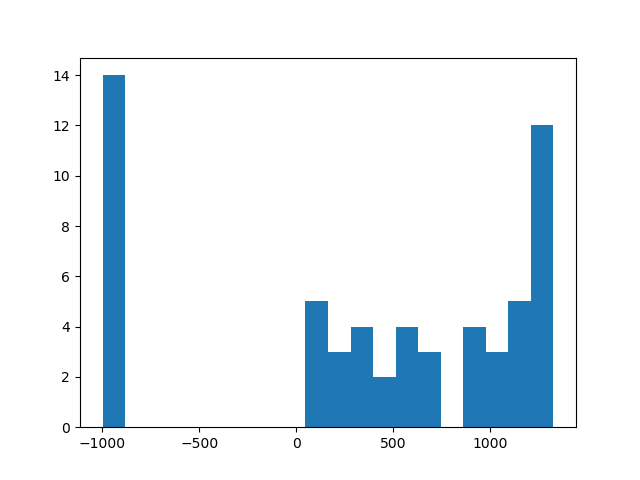

In [57]:
plt.figure()
plt.hist(data_properties.deltaT, bins = 20);

,event,S2_area,cath_area,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,ts
19,4683,2.518798e+08,1.718175e+07,1.730123e+09,-999.0,6.784226,304.425,-356.025,4,3,2024-10-28 08:47:37.765
28,4746,5.962723e+08,1.465788e+07,1.730123e+09,740.3,4.617355,-343.675,-263.725,1,1,2024-10-28 08:47:40.099


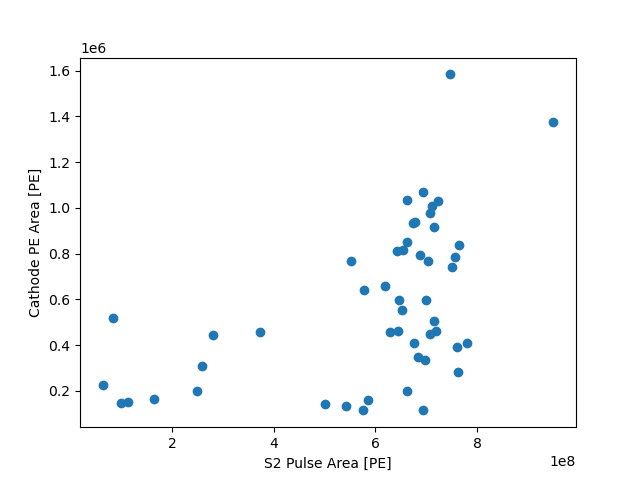

In [58]:
plt.figure()

prop_filt = data_properties[data_properties.grass_peaks == 0]

plt.scatter(prop_filt.S2_area, prop_filt.cath_area)
plt.xlabel("S2 Pulse Area [PE]")
plt.ylabel("Cathode PE Area [PE]")

display(data_properties[data_properties.cath_area > 1.25e7])

[1889.35  1935.    2074.875 2173.825]


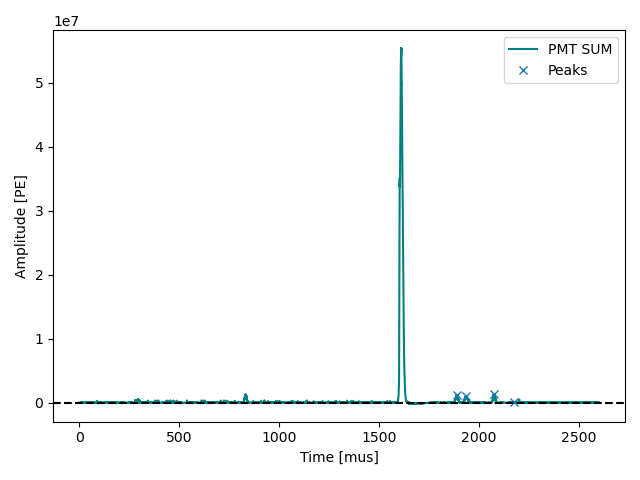

In [101]:
plt.figure()
t_pmt   = np.arange(wf_sum_clean .size) * 25e-3 # sampling period in mus
plt.plot(t_pmt , wf_sum_clean, label = "PMT SUM", color = "Teal");

# peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=noise[6], distance=0.3/tc)
peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=3000, width=0.5/tc)
print(peaks*tc+grass_lim[0])

# peaks, _ = find_peaks(wf_sum_clean[ int(100/tc):int(985/tc)], height=10000, distance=40/tc)
# print(peaks*tc+100)

# peaks, _ = find_peaks(wf_sum_15[ int(grass_lim[0]/25e-3):int(grass_lim[1]/25e-3)], height=noise[15], distance=1/25e-3)


plt.plot(t_pmt[peaks+int(grass_lim[0]/25e-3)], wf_sum_clean[peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')

# plt.axhline(y=0, color='black', linestyle='--')

# plt.semilogy()
plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [PE]")

# plt.xlim(1300, 1900)
# plt.ylim(-100, 1000)

plt.legend()
plt.tight_layout()

plt.axhline(y=0, color='black', linestyle='--')

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,4550,1.730123e+09,0,1730.732992,1656.350,121.339707,2024-10-28 08:47:33.196
1,4550,1.730123e+09,0,2326.133235,1698.325,121.339707,2024-10-28 08:47:33.196
2,4550,1.730123e+09,0,800.507125,1792.500,121.339707,2024-10-28 08:47:33.196
3,4550,1.730123e+09,0,2477.790330,2125.500,121.339707,2024-10-28 08:47:33.196
4,4550,1.730123e+09,0,2352.537031,2197.250,121.339707,2024-10-28 08:47:33.196
...,...,...,...,...,...,...,...
44621,4956,1.730123e+09,59,933.691598,1917.275,106.014045,2024-10-28 08:47:48.250
44622,4956,1.730123e+09,59,1144.652447,2022.325,106.014045,2024-10-28 08:47:48.250
44623,4956,1.730123e+09,59,765.517090,2235.475,106.014045,2024-10-28 08:47:48.250
44624,4956,1.730123e+09,59,923.623385,2242.875,106.014045,2024-10-28 08:47:48.250


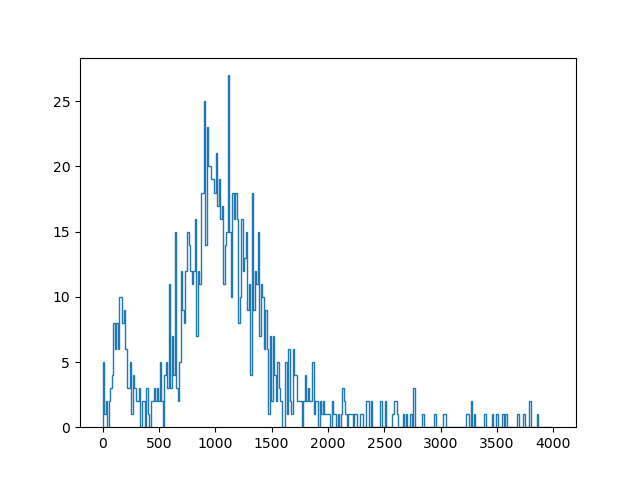

In [60]:
display(data)
plt.figure()
# for pmt in data.pmt.unique():
    # if (pmt <= 50 and pmt >= 49):
    # plt.hist(data[data.pmt == pmt].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = pmt);


# plt.hist(data[data.pmt == 0].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 12");
plt.hist(data[data.pmt == 1].pe_int, bins = np.linspace(0, 4000, 300), histtype = "step",  label = "PMT 13");
# plt.hist(data[data.pmt == 2].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 14");
# plt.hist(data[data.pmt == 3].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 15");
# plt.hist(data[data.pmt == 4].pe_int, bins = np.arange(0, 300, 1), histtype = "step");
# plt.hist(data[data.pmt == 10].pe_int, bins = np.arange(0, 300, 2), histtype = "step");




# plt.legend()

4550 0.5854120292999807
4557 0.3957841557610343
4564 0.3988153686153847
4571 0.7213564300132764
4578 0.45003146026716884
4592 0.2963729116172124
4599 0.992161590108869
4613 0.8361733174787342
4620 0.1271991406117557
4634 0.6306420794856884
4641 0.7623061114155636
4655 0.4353354519317702
4662 0.8036201445989948
4676 0.4892039269579997
4690 0.4812109307452221
4711 0.3857068559193548
4718 0.9046343669976162
4732 0.7269907668785871
4739 0.43406756337673613
4753 0.4399723781554422
4760 0.33739502635153923
4788 0.15044529015407743
4802 0.8022371973382706
4809 0.18632172341833322
4830 0.10706013061890482
4837 0.4503291106235684
4844 0.5187323867777944
4851 0.9959854693560805
4858 0.15605895436296494
4872 0.11428262083313778
4879 0.12911491142508083
4886 0.774571329965614
4893 0.1448886079058319
4900 0.3232494239803747
4928 0.1876713102593327
4935 0.14355104823306622
4949 0.28132261370319595


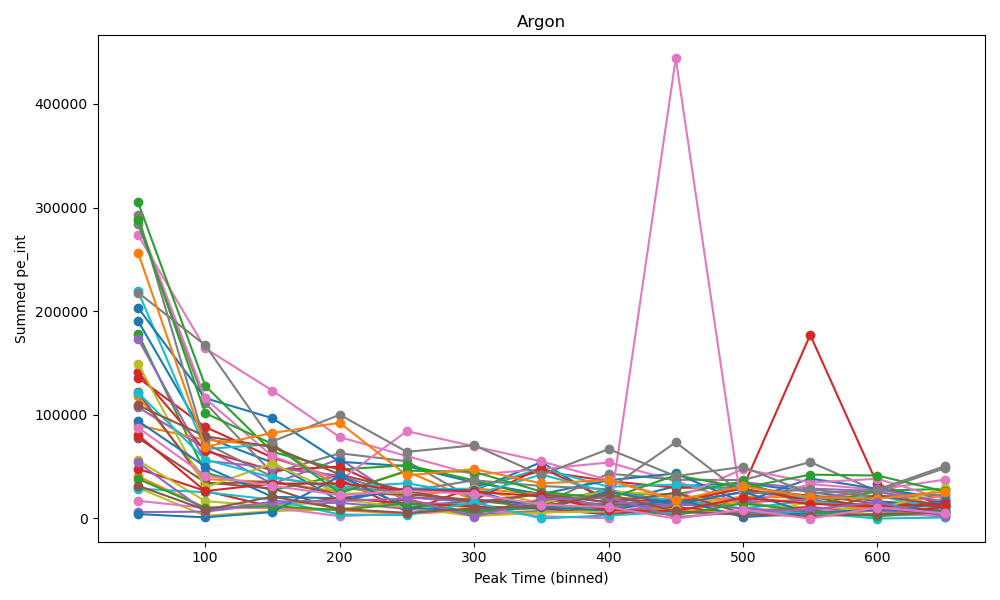

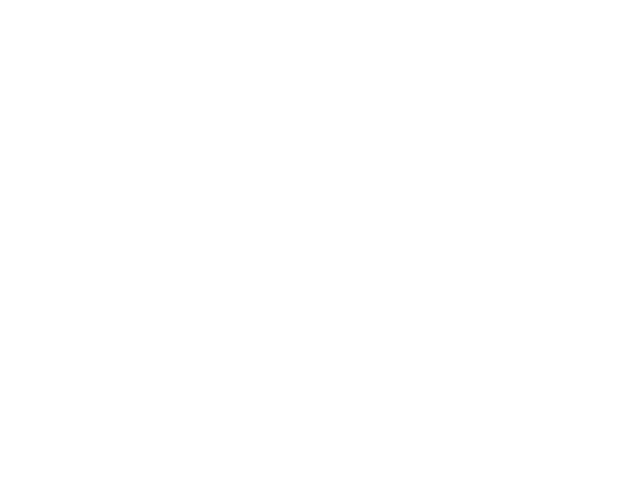

In [126]:
# Plot the PE charge vs time in the window
plt.figure()

# 1. Group by 'event' and sum 'pe_int' for each event
# summed_pe_int = data.groupby('event')['pe_int'].sum()

# 1. Define bins for peak_time from 1350 to 1770 in steps of 10
bins = np.arange(grass_lim[0], grass_lim[1], 50)  # Bins from 1350 to 1770 with step of 10
data['peak_time_bin'] = pd.cut(data['peak_time'], bins, include_lowest=True, labels=bins[:-1])

# 2. Group by 'event' and 'peak_time_bin', then sum 'pe_int'
grouped = data.groupby(['event', 'peak_time_bin'])['pe_int'].sum().reset_index()

# 3. Plot each event as a separate curve
plt.figure(figsize=(10, 6))

for index, event in enumerate(grouped['event'].unique()):
    event_data = grouped[grouped['event'] == event]
    S2_pulse = data_properties[data_properties['event'] == event]


    # if (index >10):
    #     continue

    if (S2_pulse.grass_peaks.iloc[0]>0):
        continue

    print(event, event_data['pe_int'].astype(float).sum()/1e6)

    plt.plot(event_data['peak_time_bin'].astype(float)-1600, event_data['pe_int'], marker='o', linestyle='-', label=f'Event {event}')
    # plt.plot(event_data['peak_time_bin'], event_data['pe_int']/S2_pulse.S2_area.item(), marker='o', linestyle='-', label=f'Event {event}')

# 4. Customize plot
plt.xlabel('Peak Time (binned)')
plt.ylabel('Summed pe_int')
plt.title('Argon')
# plt.xticks(bins, rotation=45)
# plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()



